# Tarea Número 3

**Nombre:** Roberto Salazar

## Ejercicio 1

En este ejercicio vamos a usar la tabla de datos SpotifyTop2018_40_V2.csv, que contiene una lista de 40 de las canciones más reproducidas en Spotify en el año 2018. Los datos incluyen una serie de características importantes del audio de cada canción.

La tabla contiene 40 filas y 11 columnas, las cuales se explican a continuación.

- **danceability:** Describe qué tan apta para bailar es la canción 
- **denergy:** Representa una medida de intensidad y actividad.
- **dloudness:** Sonoridad general de la pista en decibelios.
- **dspeechiness:** Detecta la presencia de palabras en la canción. 
- **dacousticness:** Indica qué tan acústica es la canción. 
- **dinstrumentalness:** Indica si la canción contiene o no voces. 
- **dliveness:** Detecta la presencia de público en la grabación.
- **dvalence:** Describe la positividad musical transmitida por la canción. 
- **dtempo:** Es el tempo estimado general de una pista en beats por minuto. 
- **dduration_ms:** Es la duración de la canción en milisegundos.
- **dtime signature:** Especifica cuantos beats hay en cada barra o medida. 

Nota: Todas son variables numéricas y no tienen NA. Realice lo siguiente:

#### *a)* Cargue la tabla de datos **SpotifyTop2018_40_V2.csv**

##### Clases Utilizadas

In [ ]:
# %load ../LinkageMethod.py
from enum import Enum

class LinkageMethod(Enum):

    SINGLE = "single",
    AVERAGE = "average",
    COMPLETE = "complete",
    WARD = "ward"


In [ ]:
# %load ../Process.py
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, ward, single, complete,average,linkage, fcluster
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from math import pi

from LinkageMethod import LinkageMethod
from ACP import ACP

class Process:

    # Constructor
    def __init__(self):
        self.__data = None
        self.__hierarchical_method = None
        self.__centers = None
        self.__groups = None

    def load_data(self, path = "", file = "", delimiter = ";", decimal = ".", index_col = 0, columns_to_exclude = [], recode_colums = [], use_dummies = False):
        os.chdir(path)
        preilimary_data = pd.read_csv(file, delimiter = delimiter, decimal = decimal, index_col = index_col)
        
        if len(columns_to_exclude) > 0:
            preilimary_data = preilimary_data.drop(columns_to_exclude, 1)

        if use_dummies:
            preilimary_data = pd.get_dummies(preilimary_data)

        # Centrar y reducir
        self.data = pd.DataFrame(StandardScaler().fit_transform(preilimary_data), index = preilimary_data.index.tolist())
        self.data.columns = preilimary_data.columns
        
        print(self.data)

    def idenfity_hierarchical_cluster(self, method = LinkageMethod.SINGLE):
        self.hierarchical_method = self.__get_linkage_method(method)
        
    def plot_dendogram(self, cut_values = []):
        plt.figure(figsize=(20,20))
        dendrogram(self.hierarchical_method,labels = self.data.index.tolist())
        for cut in cut_values:
            self.__add_cut_to_dendogram(cut["value"], cut["text"])

    def __add_cut_to_dendogram(self, cut_value = None, cut_text = ""):
        ax = plt.gca()
        limites = ax.get_xbound()
        ax.plot(limites, [cut_value, cut_value], '--', c = 'k')
        ax.text(limites[1], cut_value, cut_text, va = 'center', fontdict = {'size': 15})

    def draw_bars(self, method = LinkageMethod.SINGLE, metric = "euclidean", num_clusters = 3):
        self.__setup_groups_and_centers(method = method, num_clusters = num_clusters)
        plt.figure(1, figsize = (12, 8))
        self.__bar_plot(self.centers, self.data.columns)

    def draw_radar(self, method = LinkageMethod.SINGLE, metric = "euclidean", num_clusters = 3):
        self.__setup_groups_and_centers(method = method, num_clusters = num_clusters)
        plt.figure(1, figsize = (10, 10))
        self.__radar_plot(self.centers, self.data.columns)

    def draw_acp_plain(self):
        acp = ACP(self.data, n_componentes = 3)
        acp.plot_plano_principal(groups = self.groups)

    def __setup_groups_and_centers(self, method = LinkageMethod.SINGLE, metric = "euclidean", num_clusters = 3):
        if self.groups is None:
            groups = fcluster(linkage(pdist(self.data), method = method.value, metric = metric), num_clusters, criterion = 'maxclust')
            self.groups = groups - 1
        
        if self.centers is None:
            array = []
            for i in range(num_clusters):
                array.append(self.centroid(i, self.data, self.groups))
            self.centers = np.array(pd.concat(array))

    def __bar_plot(self, centros, labels, cluster = None, var = None):
        from math import ceil, floor
        from seaborn import color_palette
        colores = color_palette()
        minimo = floor(centros.min()) if floor(centros.min()) < 0 else 0
        def inside_plot(valores, labels, titulo):
            plt.barh(range(len(valores)), valores, 1/1.5, color = colores)
            plt.xlim(minimo, ceil(centros.max()))
            plt.title(titulo)
        if var is not None:
            centros = np.array([n[[x in var for x in labels]] for n in centros])
            colores = [colores[x % len(colores)] for x, i in enumerate(labels) if i in var]
            labels = labels[[x in var for x in labels]]
        if cluster is None:
            for i in range(centros.shape[0]):
                plt.subplot(1, centros.shape[0], i + 1)
                inside_plot(centros[i].tolist(), labels, ('Cluster ' + str(i)))
                plt.yticks(range(len(labels)), labels) if i == 0 else plt.yticks([]) 
        else:
            pos = 1
            for i in cluster:
                plt.subplot(1, len(cluster), pos)
                inside_plot(centros[i].tolist(), labels, ('Cluster ' + str(i)))
                plt.yticks(range(len(labels)), labels) if pos == 1 else plt.yticks([]) 
                pos += 1

    def __radar_plot(self, centros, labels):
        centros = np.array([((n - min(n)) / (max(n) - min(n)) * 100) if 
                            max(n) != min(n) else (n/n * 50) for n in centros.T])
        angulos = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
        angulos += angulos[:1]
        ax = plt.subplot(111, polar = True)
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        
        plt.xticks(angulos[:-1], labels)
        ax.set_rlabel_position(0)
        plt.yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            ["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"], 
            color = "grey", size = 8)
        plt.ylim(-10, 100)
        for i in range(centros.shape[1]):
            valores = centros[:, i].tolist()
            valores += valores[:1]
            ax.plot(angulos, valores, linewidth = 1, linestyle = 'solid', 
                    label = 'Cluster ' + str(i))
            ax.fill(angulos, valores, alpha = 0.3)
        plt.legend(loc='upper right', bbox_to_anchor = (0.1, 0.1))

    def centroid(self, num_cluster, data, clusters):
        ind = clusters == num_cluster
        return(pd.DataFrame(data[ind].mean()).T)

    def __get_linkage_method(self, method = LinkageMethod.SINGLE):
        if method == LinkageMethod.SINGLE:
            return single(self.data)
        elif method == LinkageMethod.COMPLETE:
            return complete(self.data)
        elif method == LinkageMethod.AVERAGE:
            return average(self.data)
        else:
            return ward(self.data)

    @property 
    def data(self):
        return self.__data
    
    @data.setter
    def data(self, data):
        self.__data = data
    
    @property 
    def hierarchical_method(self):
        return self.__hierarchical_method
    
    @hierarchical_method.setter
    def hierarchical_method(self, hierarchical_method):
        self.__hierarchical_method = hierarchical_method

    @property 
    def centers(self):
        return self.__centers
    
    @centers.setter
    def centers(self, centers):
        self.__centers = centers

    @property 
    def groups(self):
        return self.__groups
    
    @groups.setter
    def groups(self, groups):
        self.__groups = groups

In [1]:
from Process import Process
from LinkageMethod import LinkageMethod

process1 = Process()
process1.load_data("./resources", "SpotifyTop2018_40_V2.csv", ",", ".")

                                               danceability    energy  \
Dura                                               0.480209  1.366798   
Plug_Walk                                          1.048703 -1.049844   
Silence                                           -1.332280  0.727747   
Solo_(feat._Demi_Lovato)                           0.119049 -0.190430   
Sin_Pijama                                         0.480209  0.610220   
Call_Out_My_Name                                  -1.539613 -0.469556   
Taki_Taki_(with_Selena_Gomez_Ozuna_&_Cardi_B)      0.814617  0.999527   
River_(feat._Ed_Sheeran)                           0.192619  0.639602   
Rewrite_The_Stars                                 -0.235423 -0.315302   
Him_&_I_(with_Halsey)                             -0.870798  0.507385   
Look_Alive_(feat._Drake)                           1.356358 -0.594428   
Rise                                              -0.215359  0.904037   
Perfect                                           -

#### *b)* Ejecute un Clustering Jerárquico con la agregación del Salto Máximo, Salto Mínimo,
Promedio y Ward. Grafique el dendograma con cortes para dos y tres clústeres.

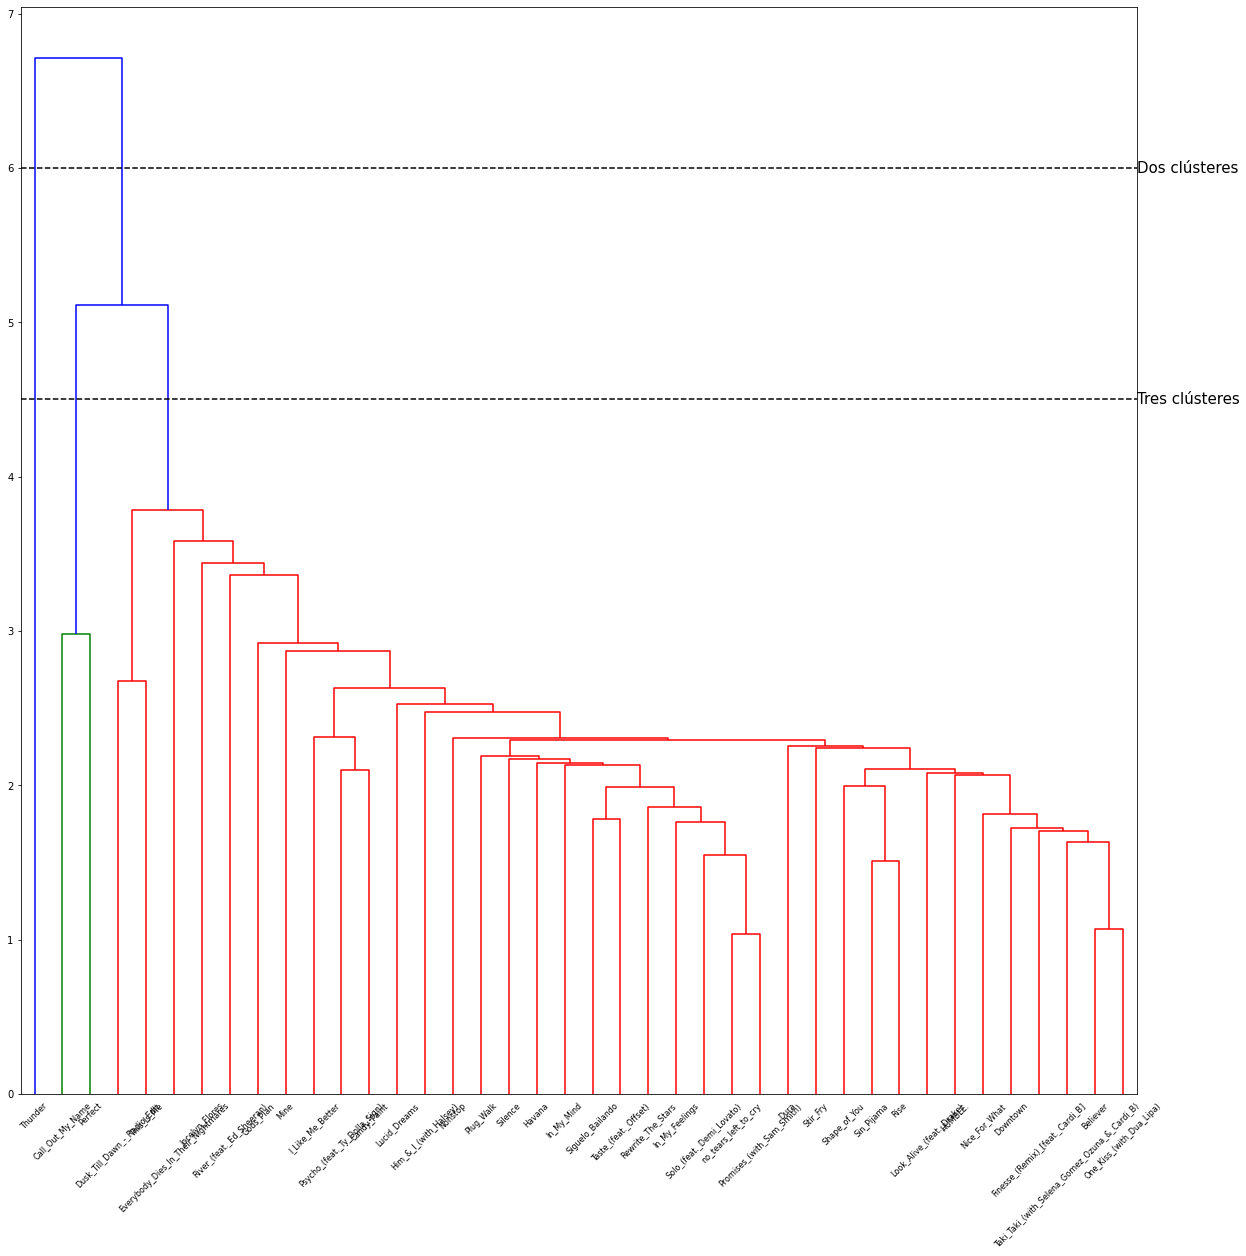

In [2]:
# Cluster con Salto Mínimo
process1.idenfity_hierarchical_cluster(LinkageMethod.SINGLE)

cuts = [
    {"value": 6, "text": "Dos clústeres"},
    {"value": 4.5, "text": "Tres clústeres"}
]

process1.plot_dendogram(cut_values = cuts)

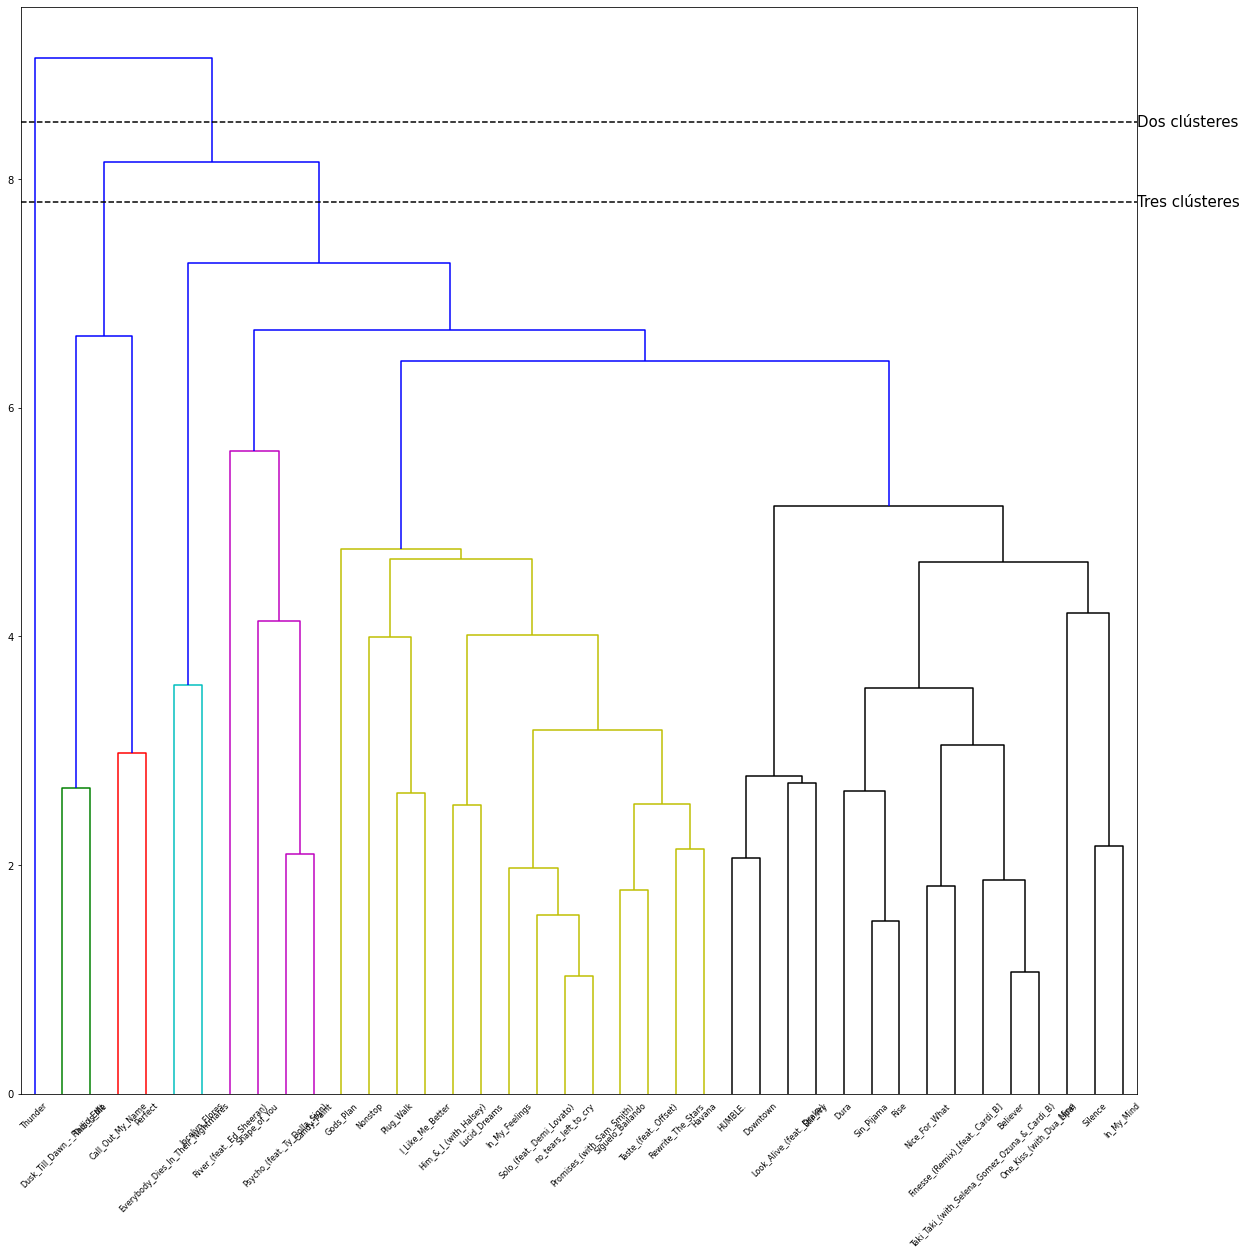

In [3]:
# Cluster con Salto Máximo
process1.idenfity_hierarchical_cluster(LinkageMethod.COMPLETE)

cuts = [
    {"value": 8.5, "text": "Dos clústeres"},
    {"value": 7.8, "text": "Tres clústeres"}
]

process1.plot_dendogram(cut_values = cuts)

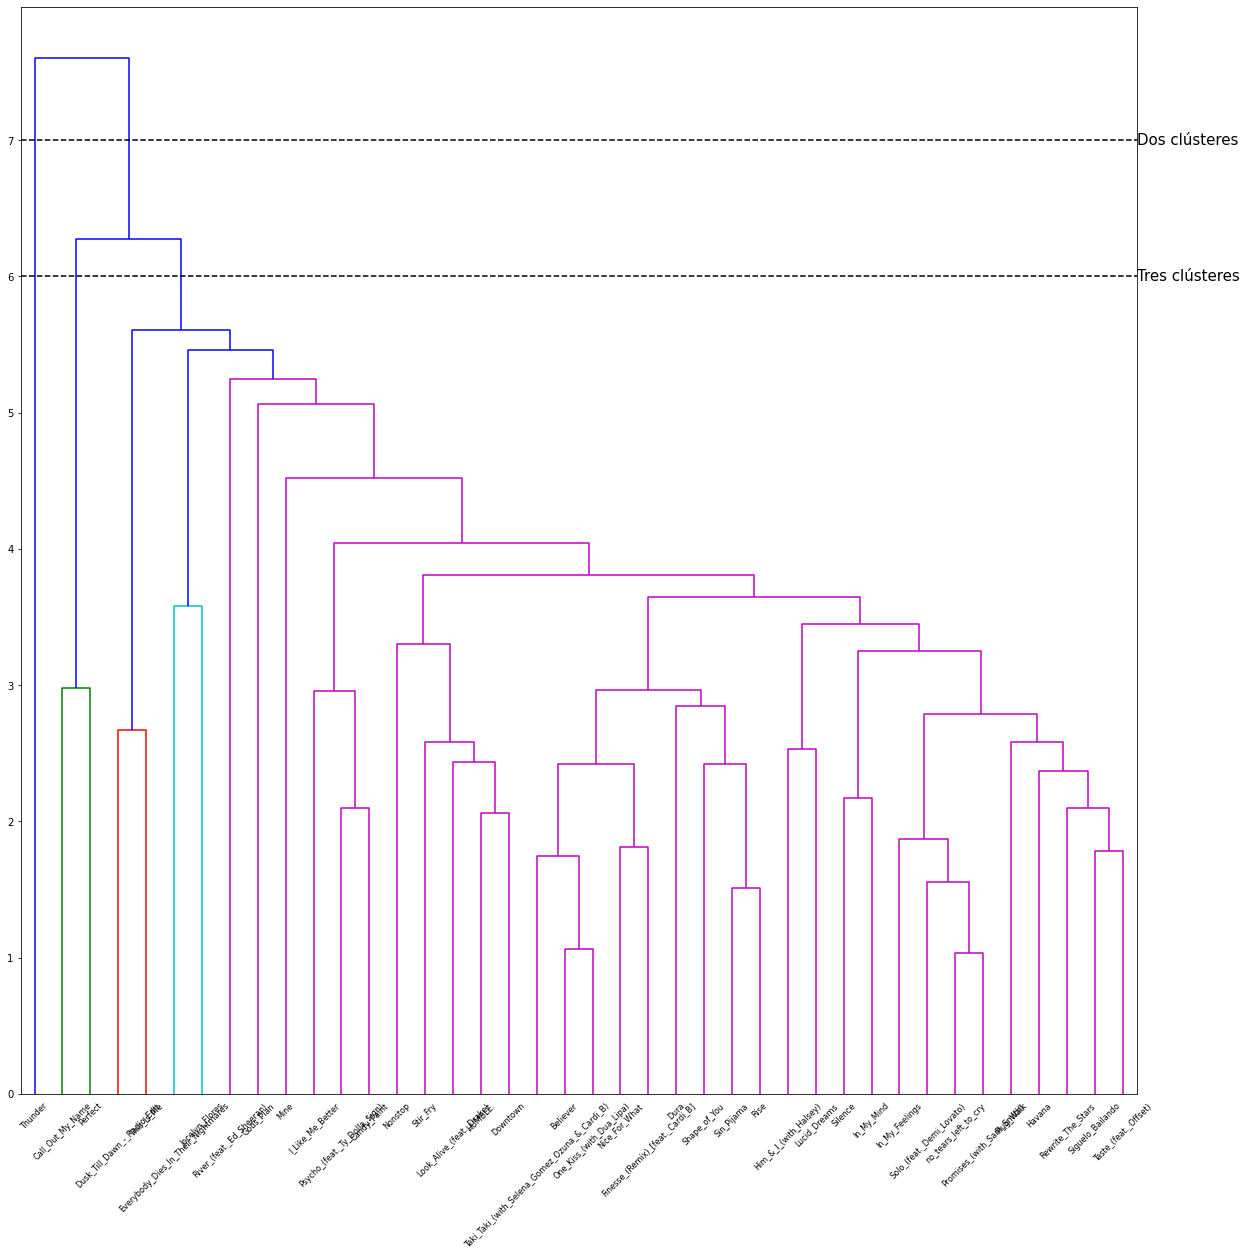

In [4]:
# Cluster con Salto Promedio
process1.idenfity_hierarchical_cluster(LinkageMethod.AVERAGE)

cuts = [
    {"value": 7, "text": "Dos clústeres"},
    {"value": 6, "text": "Tres clústeres"}
]

process1.plot_dendogram(cut_values = cuts)

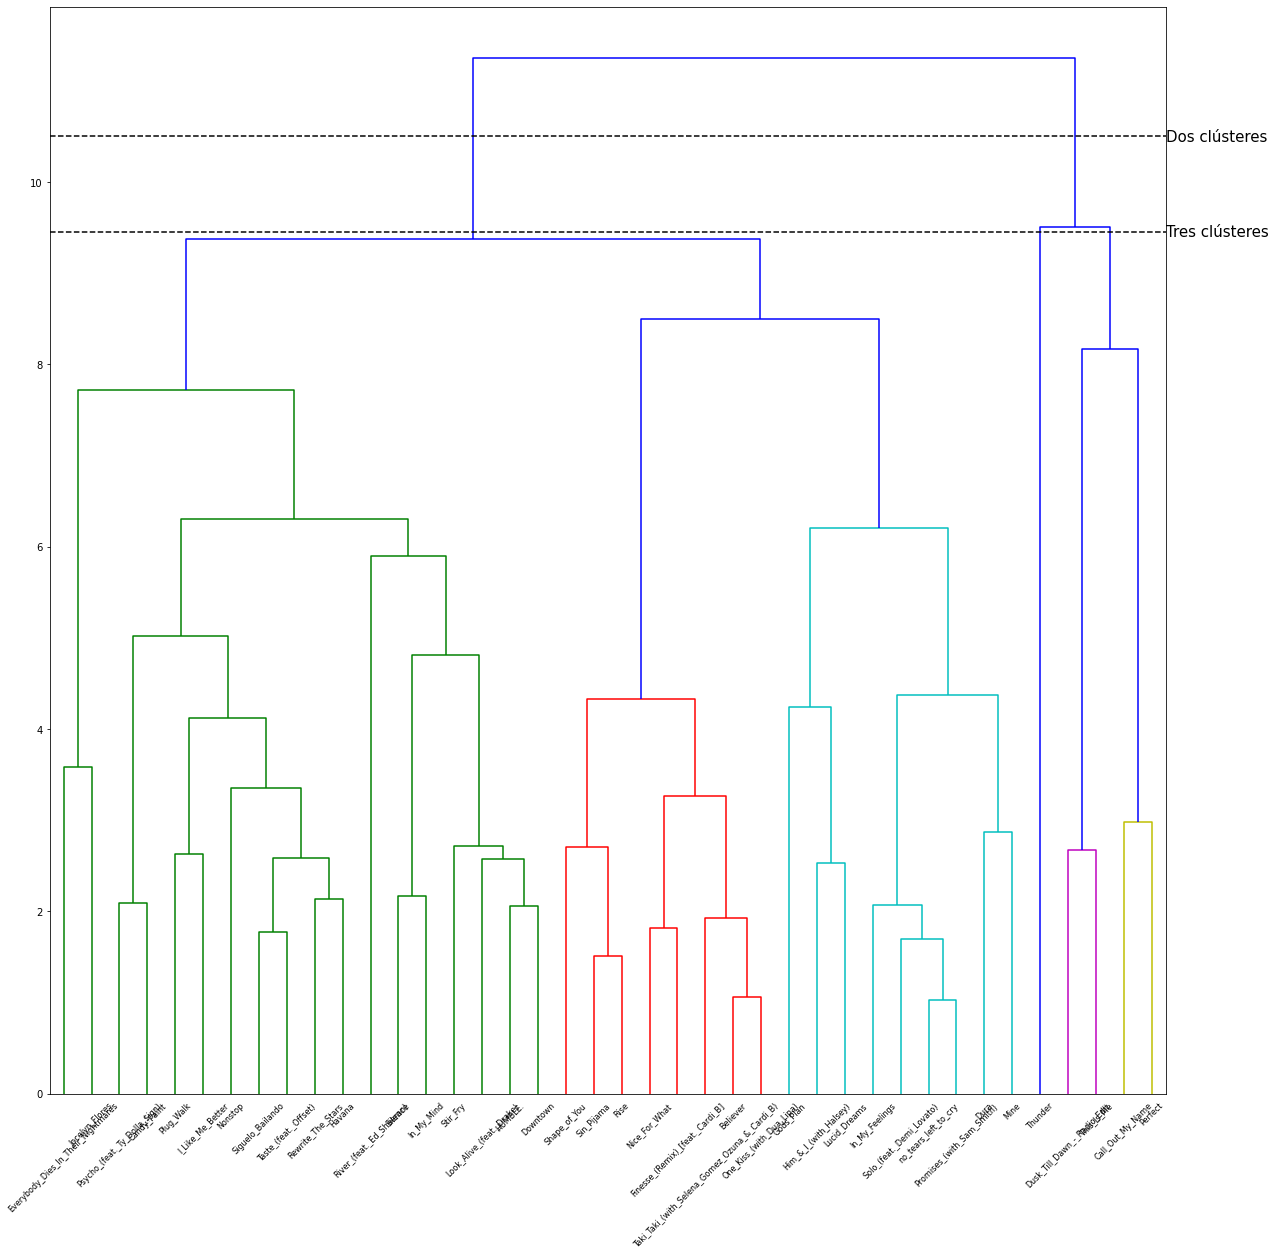

In [5]:
# Cluster con Salto Ward
process1.idenfity_hierarchical_cluster(LinkageMethod.WARD)

cuts = [
    {"value": 10.5, "text": "Dos clústeres"},
    {"value": 9.45, "text": "Tres clústeres"}
]

process1.plot_dendogram(cut_values = cuts)

#### *c)* Usando tres clústeres interprete los resultados del ejercicio anterior para el caso de agregación de Ward usando gráficos de barras y gráficos tipo Radar.

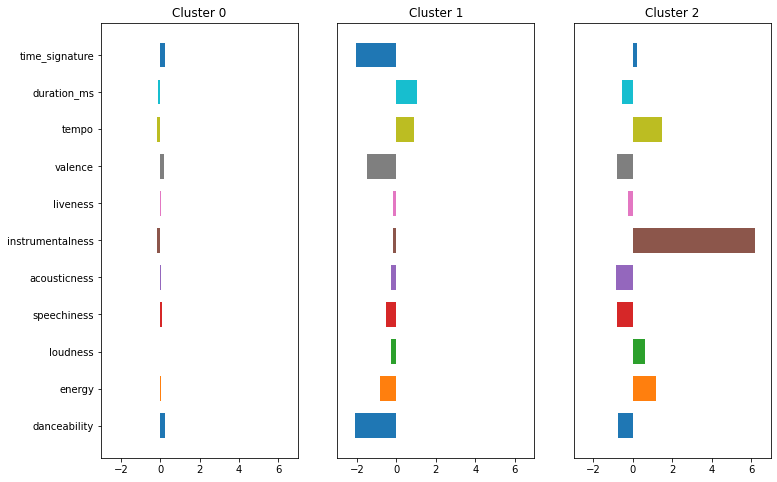

In [6]:
# Gráfico de Barras
process1.draw_bars(method = LinkageMethod.WARD, num_clusters = 3)

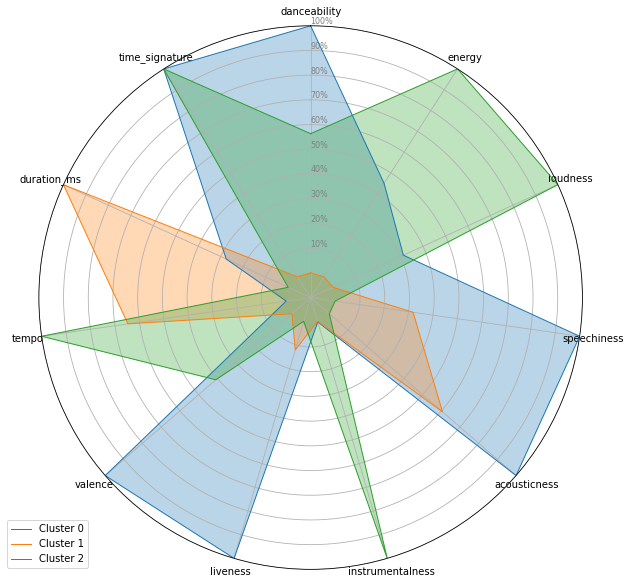

In [7]:
# Gráfico de Radar
process1.draw_radar(method = LinkageMethod.WARD, num_clusters = 3)

> **Interpretación**
- Colocar interpretación

#### *d)* Grafique usando colores sobre las dos primeras componentes del plano principal en el Análisis en Componentes Principales los clústeres obtenidos según la clasificación Jerárquica (usando tres clústeres).

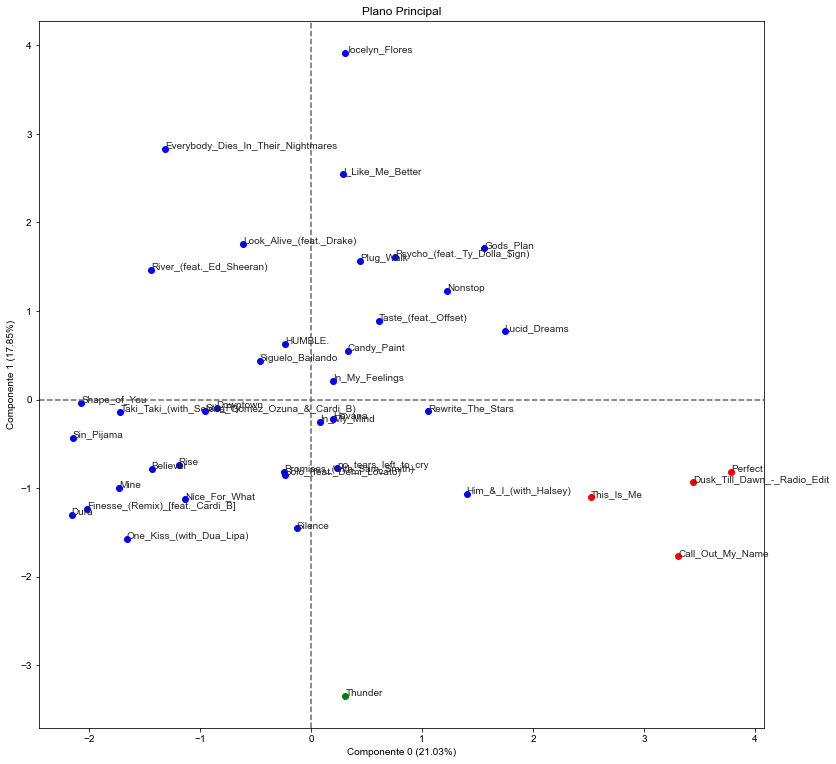

In [8]:
# Uso de ACP para gráfico de plano principal
process1.draw_acp_plain()

## Ejercicio 2

En este ejercicio vamos a realizar un Clustering Jerárquico para la tabla SAheart.csv la cual contiene variables numéricas y categóricas mezcladas. La descripción de los datos es la siguiente: Datos Tomados del libro: The Elements of Statistical Learning Data Mining, Inference, and Prediction de Trevor Hastie, Robert Tibshirani y Jerome Friedman de la Universidad de Stanford. Example: South African Heart Disease: A retrospective sample of males in a heart-disease high-risk region of the Western Cape, South Africa. There are roughly two controls per case of coronary heart disease. Many of the coronary heart disease positive men have undergone blood pressure reduction treatment and other programs to reduce their risk factors after their coronary heart disease event. In some cases the measurements were made after these treatments. These data are taken from a larger dataset, described in Rousseauw et al, 1983, South African Medical Journal. Below is a description of the variables:

- **sbp:** systolic blood pressure (numérica)
- **tobacco:** cumulative tobacco (kg) (numérica)
- **ldl:** low densiity lipoprotein cholesterol (numérica)
- **Adiposity:** (numérica)
- **famhist:** family history of heart disease (Present, Absent) (categórica) 
- **typea:** type-A behavior (numérica)
- **Obesity:** (numérica)
- **alcohol:** current alcohol consumption (numérica)
- **age:** age at onset (numérica)
- **chd:** coronary heart disease (categórica)

Las dos variables categóricas se explican como sigue: *famhist* significa que hay historia familiar de infarto y que la variable *chd* significa que la persona murió de enfermedad cardíaca coronaria.

#### *a)* Efectúe un Clustering Jerárquico usando solo las variables numéricas y dé una interpretación usando 3 clústeres.

          sbp   tobacco       ldl  adiposity     typea   obesity   alcohol  \
0    1.058564  1.823073  0.478412  -0.295503 -0.418470 -0.176786  3.277738   
1    0.277089 -0.790237 -0.159680   0.412140  0.193344  0.671373 -0.612745   
2   -0.992806 -0.774980 -0.609245   0.884332 -0.112563  0.735519 -0.541183   
3    1.546985  0.842264  0.807126   1.624141 -0.214532  1.412621  0.295062   
4   -0.211332  2.171805 -0.599577   0.305351  0.703189 -0.012856  1.647775   
..        ...       ...       ...        ...       ...       ...       ...   
457  3.696039 -0.705234  0.599263   0.812281  1.111065  0.571590 -0.696983   
458  2.133091  0.123004 -0.159680   0.861173 -0.112563  0.609602  0.068519   
459 -1.481228 -0.138545 -1.522877  -1.309364 -1.336191 -1.414575  0.392385   
460 -0.992806  0.384553  3.320823   0.692625  1.111065  0.310252  0.283203   
461 -0.309016 -0.792417  0.038515   1.029720  0.907127 -2.695129 -0.696983   

          age  
0    0.629336  
1    1.383115  
2    0.218184  

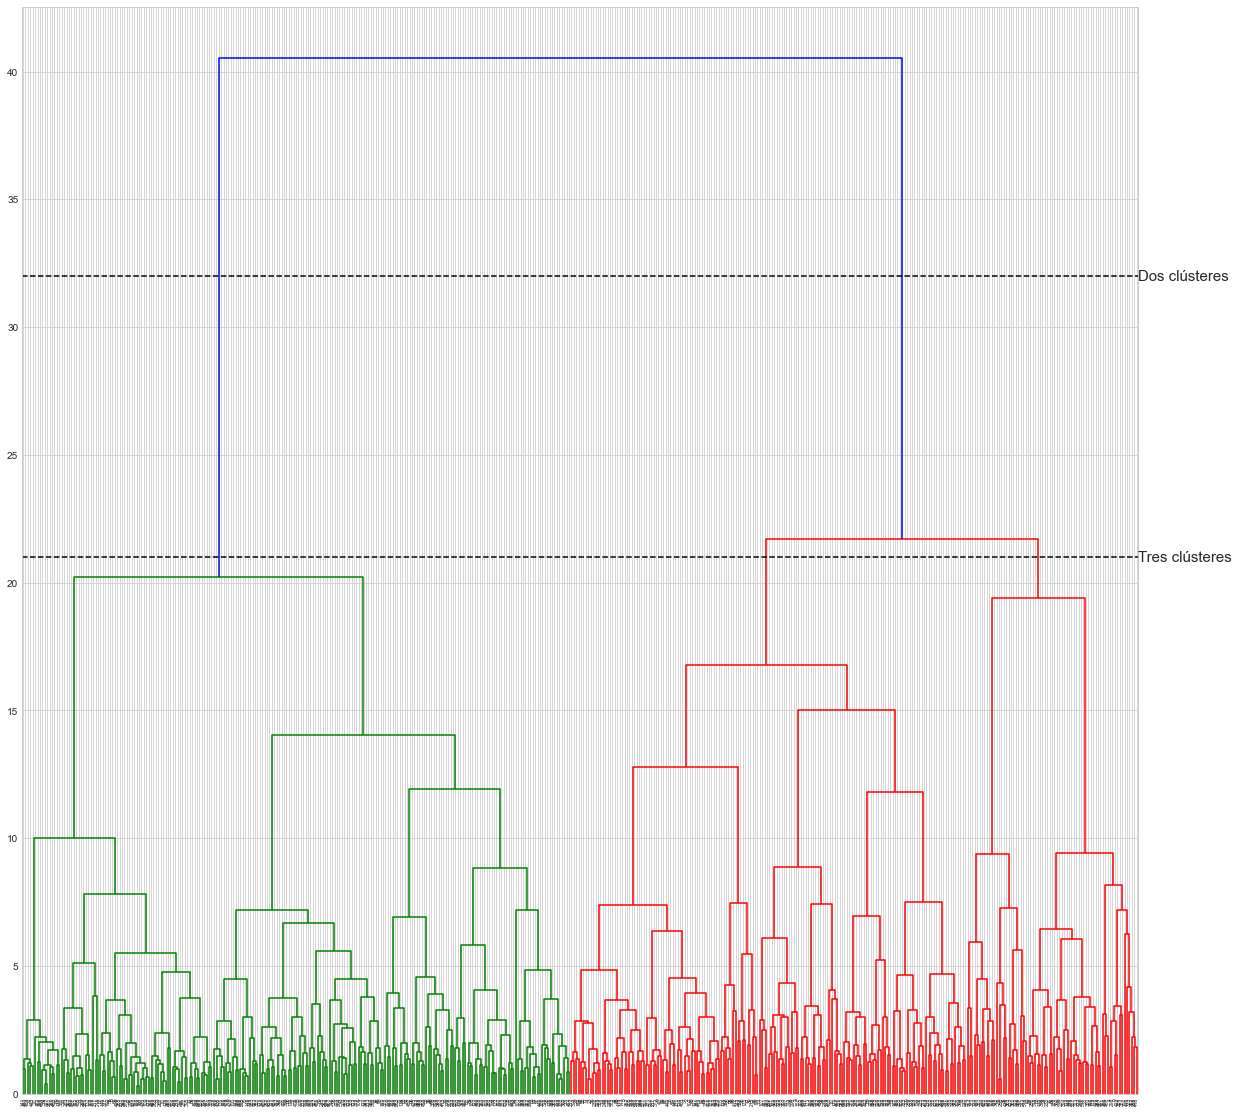

In [9]:
process2 = Process()
process2.load_data(path = "./", file = "SAheart.csv", delimiter = ";", decimal = ".", index_col = None, columns_to_exclude = ["famhist", "chd"])

# Cluster con Salto Ward
process2.idenfity_hierarchical_cluster(LinkageMethod.WARD)

cuts = [
    {"value": 32, "text": "Dos clústeres"},
    {"value": 21, "text": "Tres clústeres"}
]

process2.plot_dendogram(cut_values = cuts)

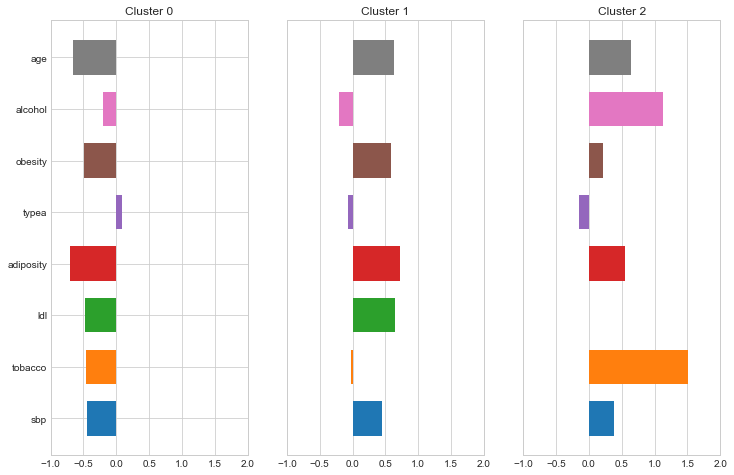

In [10]:
process2.draw_bars(method = LinkageMethod.WARD, num_clusters = 3)

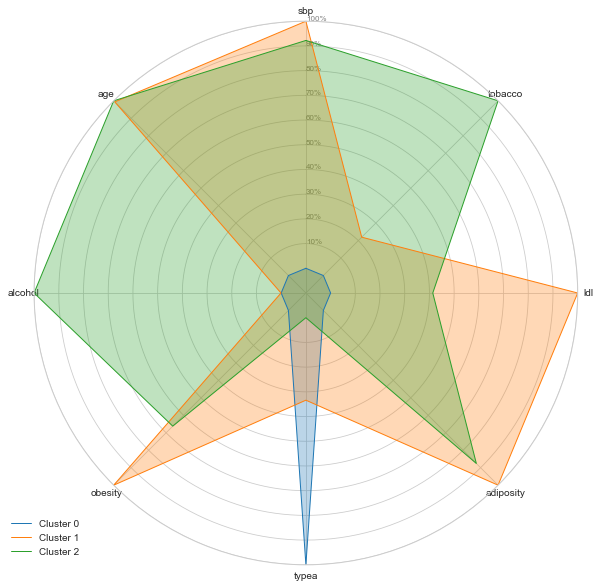

In [11]:
process2.draw_radar(method = LinkageMethod.WARD, num_clusters = 3)

#### *b)* Efectúe un Clustering Jerárquico usando las variables numéricas y las variables categóricas (recuerde recodificar las categóricas usando código disyuntivo completo). Luego dé una interpretación usando 3 clústeres.

          sbp   tobacco       ldl  adiposity     typea   obesity   alcohol  \
0    1.058564  1.823073  0.478412  -0.295503 -0.418470 -0.176786  3.277738   
1    0.277089 -0.790237 -0.159680   0.412140  0.193344  0.671373 -0.612745   
2   -0.992806 -0.774980 -0.609245   0.884332 -0.112563  0.735519 -0.541183   
3    1.546985  0.842264  0.807126   1.624141 -0.214532  1.412621  0.295062   
4   -0.211332  2.171805 -0.599577   0.305351  0.703189 -0.012856  1.647775   
..        ...       ...       ...        ...       ...       ...       ...   
457  3.696039 -0.705234  0.599263   0.812281  1.111065  0.571590 -0.696983   
458  2.133091  0.123004 -0.159680   0.861173 -0.112563  0.609602  0.068519   
459 -1.481228 -0.138545 -1.522877  -1.309364 -1.336191 -1.414575  0.392385   
460 -0.992806  0.384553  3.320823   0.692625  1.111065  0.310252  0.283203   
461 -0.309016 -0.792417  0.038515   1.029720  0.907127 -2.695129 -0.696983   

          age  famhist_Absent  famhist_Present    chd_No    chd

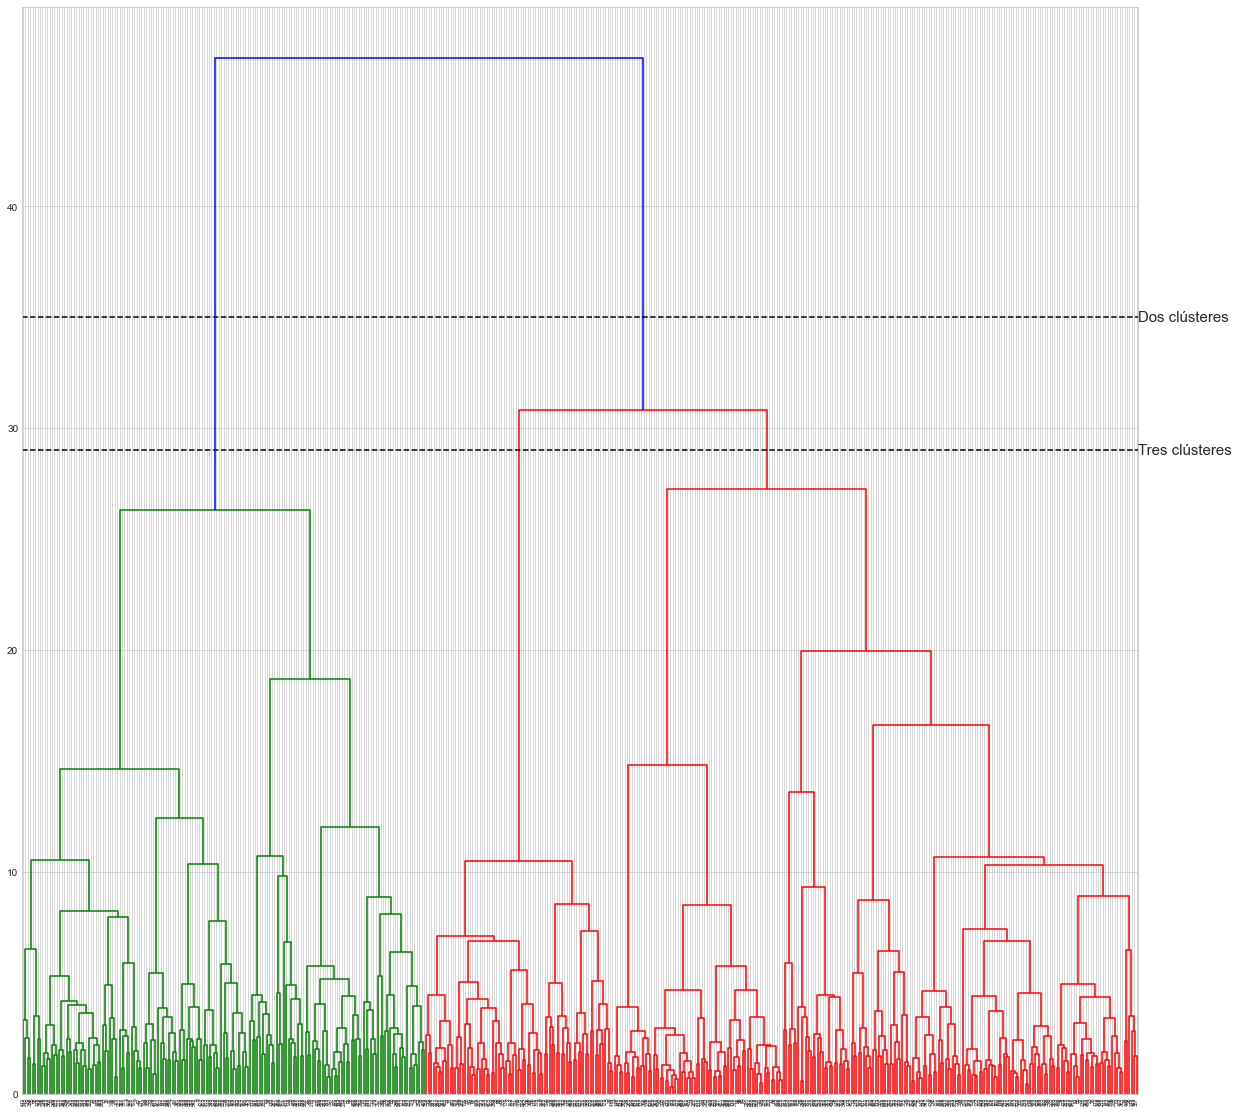

In [12]:
process3 = Process()
process3.load_data(path = "./", file = "SAheart.csv", delimiter = ";", decimal = ".", index_col = None, use_dummies = True)
process3.idenfity_hierarchical_cluster(LinkageMethod.WARD)

cuts = [
    {"value": 35, "text": "Dos clústeres"},
    {"value": 29, "text": "Tres clústeres"}
]

process3.plot_dendogram(cut_values = cuts)

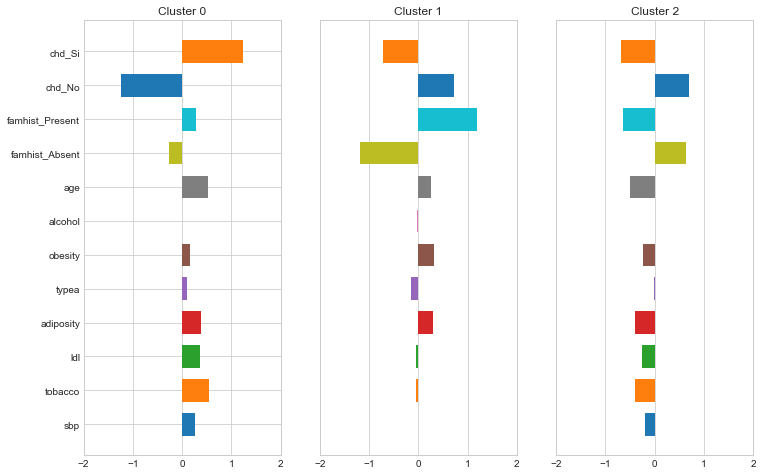

In [13]:
process3.draw_bars(method = LinkageMethod.WARD, num_clusters = 3)

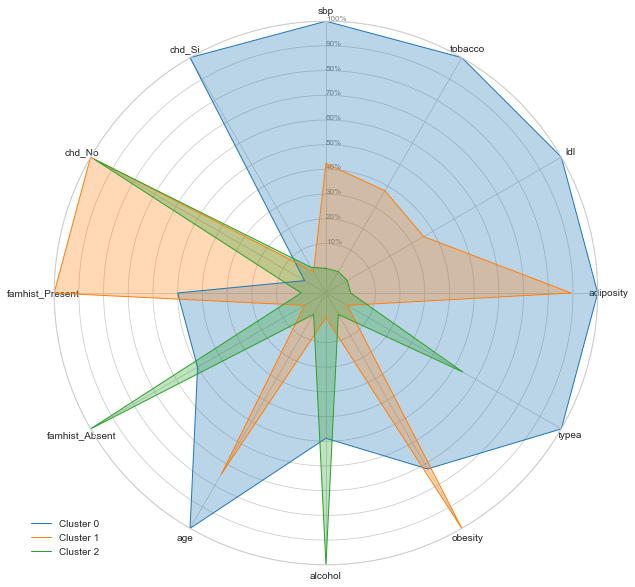

In [14]:
process3.draw_radar(method = LinkageMethod.WARD, num_clusters = 3)

#### *c)* Explique las diferencias de los dos ejercicios anteriores ¿Cuál le parece más interesante? ¿Por qué?

> **Diferencias**
1. Al incluir la variable enfermedad e historial familiar se relacionan mas estrechamente las variables alcohol y tabaco, claramente este tipo de comportamiento influye directamente en problemas del corazón
2. Al contrario que en el primer análisis, el tipo de personas con caracter type-A empiezan a mostrar cierta relación con personas que toman alcohol y suelen tener problemas de cardíacos, esto se puede interpretar como una relación estrés-enfermedad, adicionalmente se separa la relación con obesidad que aunque mínima en el anterior ejemplo existía, se podría interpretar esto con que las personas que se dedican mucho a trabajar, suelen tener poco tiempo para alimentarse, en consecuencia los problemas cardíacos podrían derivar en poca alimentación y mucho estrés

**Respuesta**  
En el primer ejemplo se nota solamente comportamientos de las personas y cierta evidencia en su apariencia, no se visualizaba las consecuencias de esos comportamientos, definitivamente se puede hacer ciertas predicciones teniendo esas variables extras y dar una estadística mas clara cerca del comportamiento y sus consecuencias.

## Ejercicio 3

Dada la siguiente matriz de disimilitudes entre cuatro individuos A1, A2, A3 y A4, construya “a mano” una Jerarquía Binaria usando la agregacio ́n del Salto Máximo, Salto Mínimo y del Promedio, dibuje el dendograma en los tres casos:

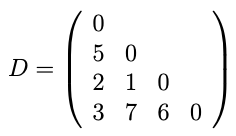

#### Salto Simple

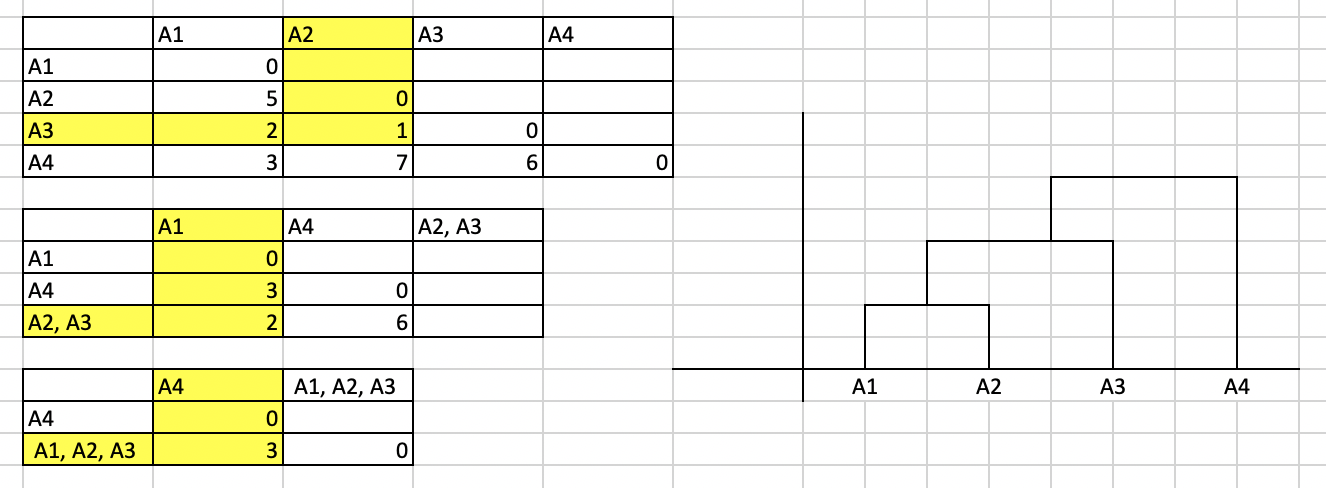

#### Salto Completo

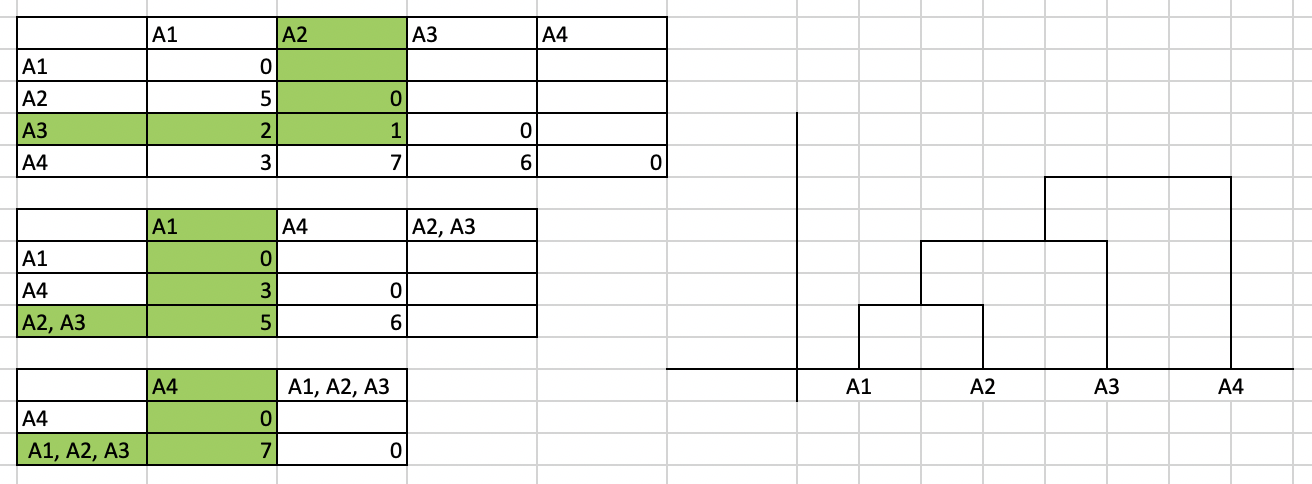

#### Salto Promedio

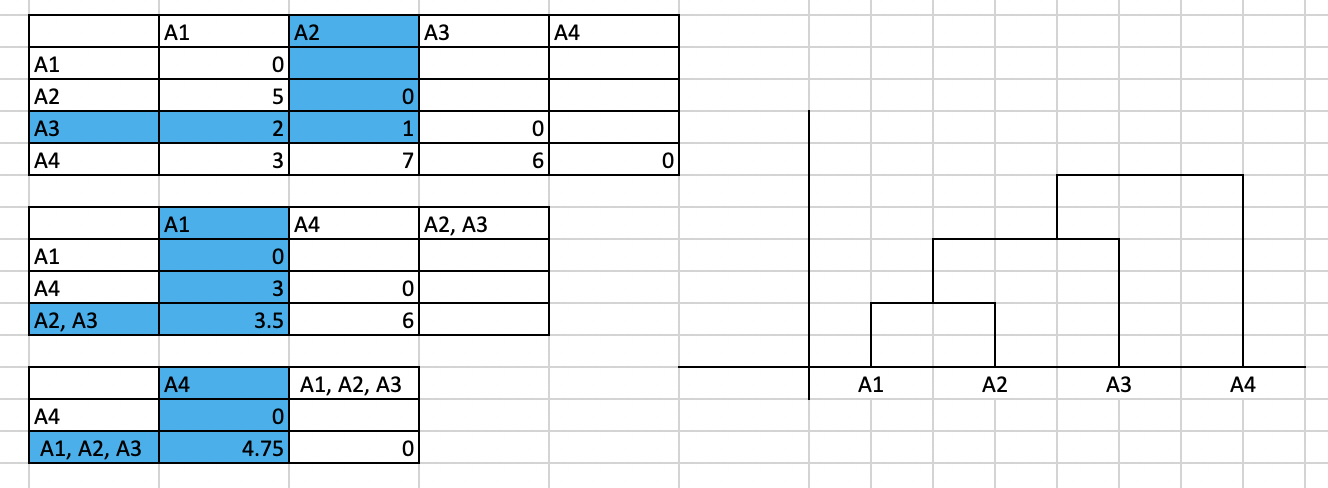

In [15]:
processManual = Process()
processManual.load_data(path = "./", file = "Ejercicio3.csv", delimiter = ";", decimal = ".")

          X1        X2        X3  X4              
A1 -1.671258  1.603567  0.447214         -0.365148
A2  0.557086 -1.069045 -0.447214          1.095445
A3  0.928477 -0.534522 -1.341641          0.730297
A4  0.185695  0.000000  1.341641         -1.460593


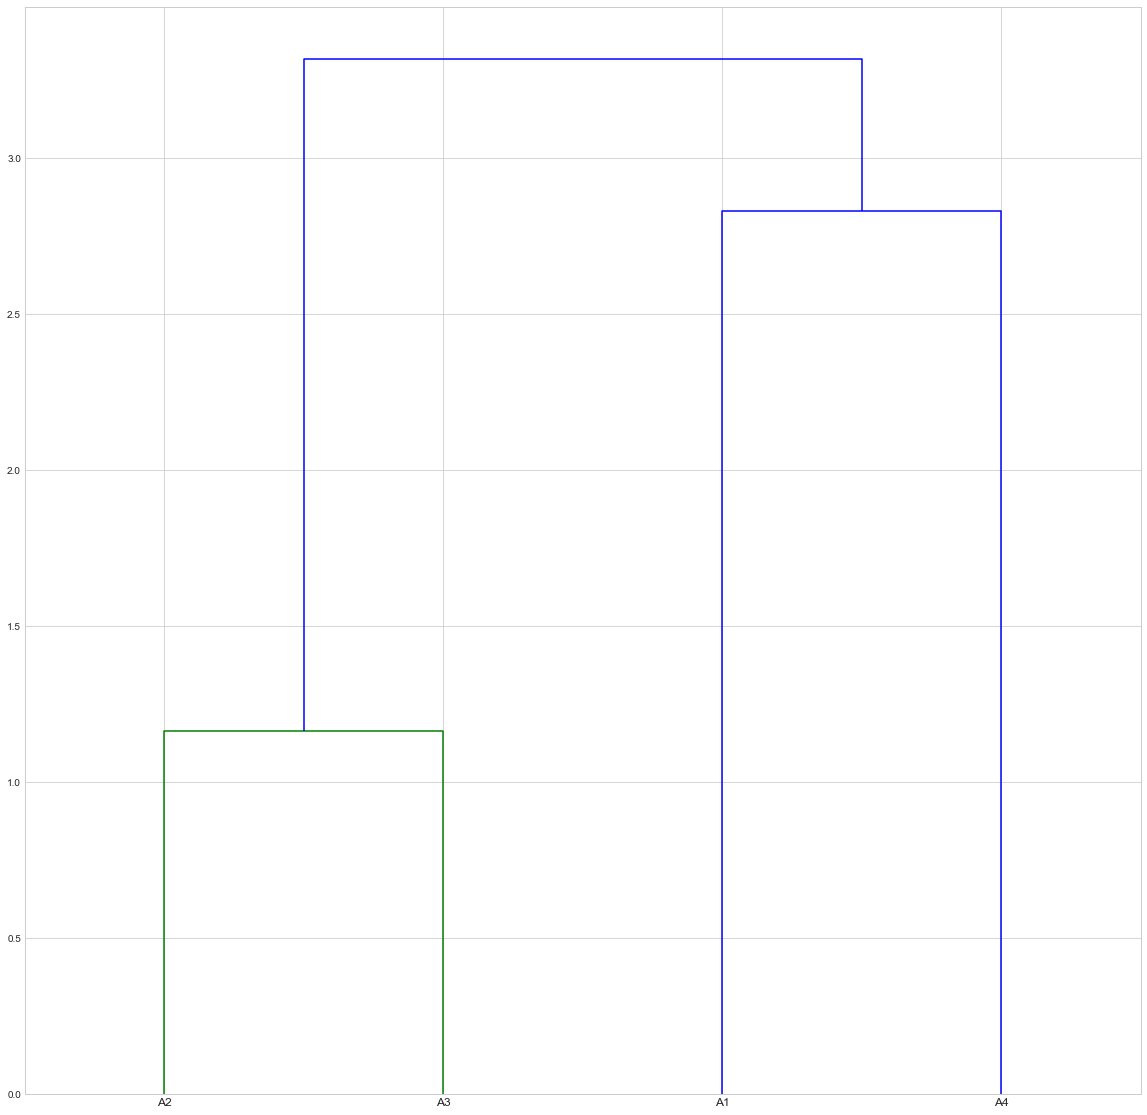

In [16]:
processManual.idenfity_hierarchical_cluster(LinkageMethod.SINGLE)
processManual.plot_dendogram()

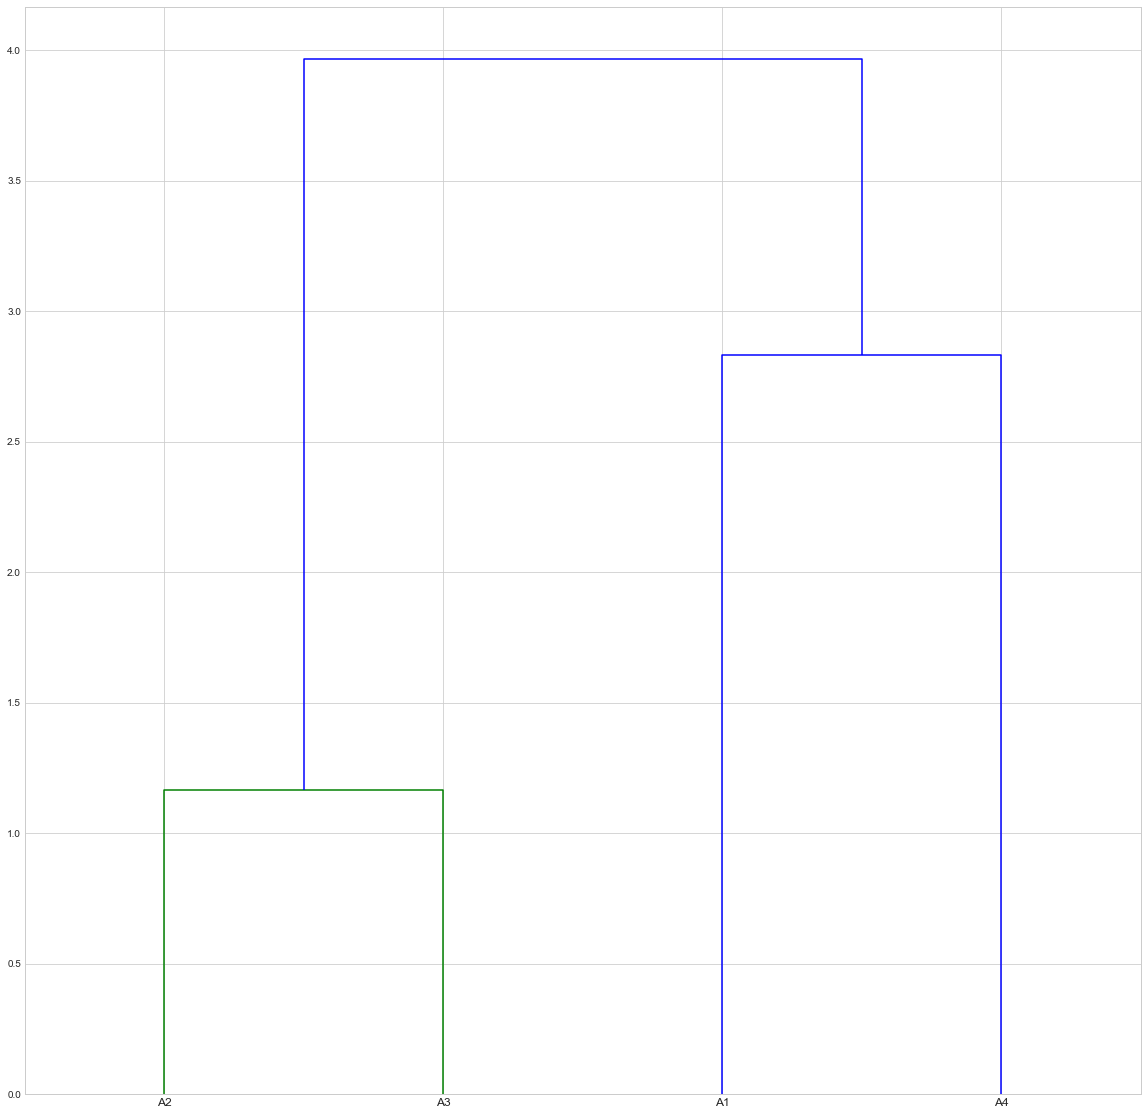

In [17]:
processManual.idenfity_hierarchical_cluster(LinkageMethod.COMPLETE)
processManual.plot_dendogram()

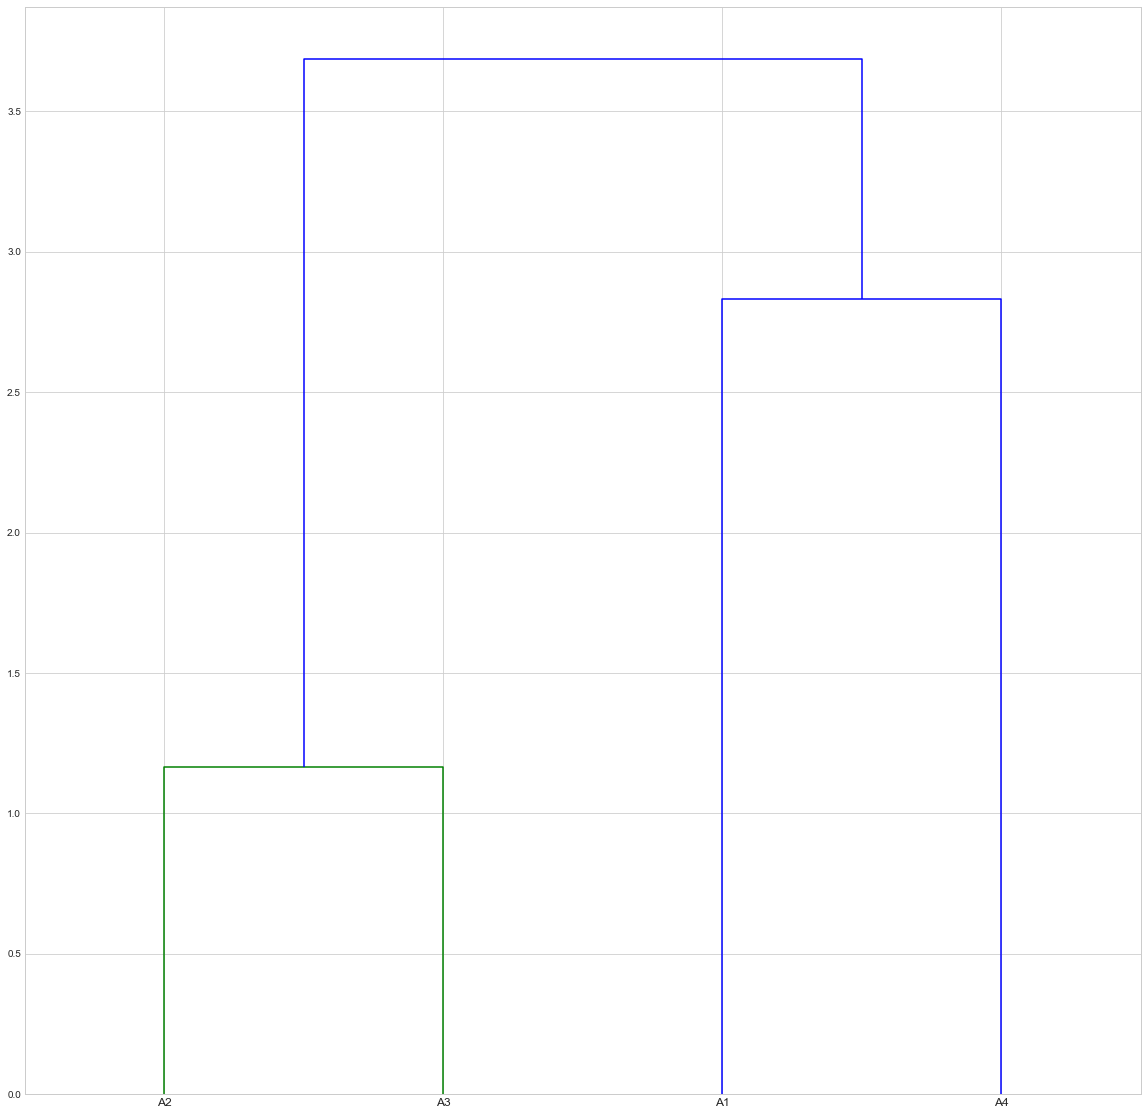

In [18]:
processManual.idenfity_hierarchical_cluster(LinkageMethod.AVERAGE)
processManual.plot_dendogram()

Verifique los resultados con scipy.cluster.hierarchy.

## Ejercicio 4

Realice lo siguiente:

Se define la distancia de Chebychev como sigue:

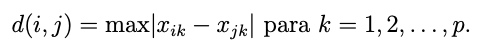

#### *a)* Programe una clase en Python que tiene un atributo tipo DataFrame, además de los métodos usuales que tiene toda clase, tendrá un método que calcula la matriz de distancias, para esto usará la distancia de Chebychev entre dos vectores que se definió arriba.

In [ ]:
# %load ../ExtendedProcess.py
from Process import Process
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, ward, single, complete,average,linkage, fcluster
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from math import pi

from LinkageMethod import LinkageMethod

class ExtendedProcess(Process):
    
    def __init__(self):
        super().__init__()

    def calculate_distances_matrix(self):
        print(pdist(self.data, metric = self.get_chebychev_formula()))

    def get_chebychev_formula(self):
        return lambda x, y: max(abs(x - y))

    def idenfity_hierarchical_cluster(self, num_clusters = 3):
        self.__setup_groups_and_centers(num_clusters = num_clusters)
        self.hierarchical_method = linkage(pdist(self.data, metric = self.get_chebychev_formula()))

    def __setup_groups_and_centers(self, num_clusters = 3):
        if self.groups is None:
            groups = fcluster(linkage(pdist(self.data, metric = self.get_chebychev_formula()), method = "centroid", metric = self.get_chebychev_formula()), num_clusters, criterion = 'maxclust')
            self.groups = groups - 1
        
        if self.centers is None:
            array = []
            for i in range(num_clusters):
                array.append(super().centroid(i, self.data, self.groups))
            self.centers = np.array(pd.concat(array))


#### *b)* Calcule la matriz de distancias usando la distancia de Chebychev para la tabla de datos EjemploEstudiantes.csv.

In [19]:
from ExtendedProcess import ExtendedProcess

process4 = ExtendedProcess()
process4.load_data(path = "./", file = "EjemploEstudiantes.csv", delimiter = ";", decimal = ",")

        Matematicas  Ciencias   Espanol  Historia  EdFisica
Lucia      0.232631 -0.752986  1.788485  0.657923  0.658581
Pedro      0.786514  1.145849 -0.538996 -0.845901 -0.476903
Ines       0.897290  1.014894  0.318497  0.093989  0.090839
Luis      -1.982900 -0.752986 -1.518987 -0.845901  1.794065
Andres    -0.875135 -1.080371  0.073499  0.939889 -0.136258
Ana        1.118843  1.276803 -0.049000  0.093989 -1.044645
Carlos    -0.542805 -0.818463  0.563495  1.033878 -0.249807
Jose       1.229620  1.342280 -0.293998  0.093989 -1.612388
Sonia     -0.875135 -1.080371 -1.518987 -2.255735  1.453420
Maria      0.011078 -0.294647  1.175990  1.033878 -0.476903


In [20]:
# Matriz de distancias con Chevychev

process4.calculate_distances_matrix()

[2.3274808  1.76788063 3.30747271 1.71498585 2.02978887 1.22498989
 2.27096842 3.30747271 1.13548421 0.93988948 2.76941379 2.22622006
 0.93988948 1.96431181 1.13548421 2.22622006 1.87977895 2.88019034
 2.09526593 1.13548421 1.83335769 1.70322632 2.34972369 1.30954121
 1.93032316 3.10174344 2.08248282 3.40645263 1.40983421 2.69497777
 2.35717418 0.48999596 2.42265124 3.19562422 1.1024909  2.09526593
 0.56774211 2.49806526 1.57144945 2.16074299 3.28961316 0.61249495
 3.06580737 1.63692651 3.28961316]
[2.3274808  1.76788063 3.30747271 1.71498585 2.02978887 1.22498989
 2.27096842 3.30747271 1.13548421 0.93988948 2.76941379 2.22622006
 0.93988948 1.96431181 1.13548421 2.22622006 1.87977895 2.88019034
 2.09526593 1.13548421 1.83335769 1.70322632 2.34972369 1.30954121
 1.93032316 3.10174344 2.08248282 3.40645263 1.40983421 2.69497777
 2.35717418 0.48999596 2.42265124 3.19562422 1.1024909  2.09526593
 0.56774211 2.49806526 1.57144945 2.16074299 3.28961316 0.61249495
 3.06580737 1.63692651 3.28

#### *c)* Para la tabla de datos EjemploEstudiantes.csv ejecute un Clustering Jerárquico usando la distancia de *Chebychev* programada por usted y la agregación Ward, compare el resultado respecto a usar distancia *euclidiana* y agregación de Ward. (Debe investigar cómo usar una distancia propia en scipy.cluster.hierarchy.

##### Utilización de Distancia Chebychev

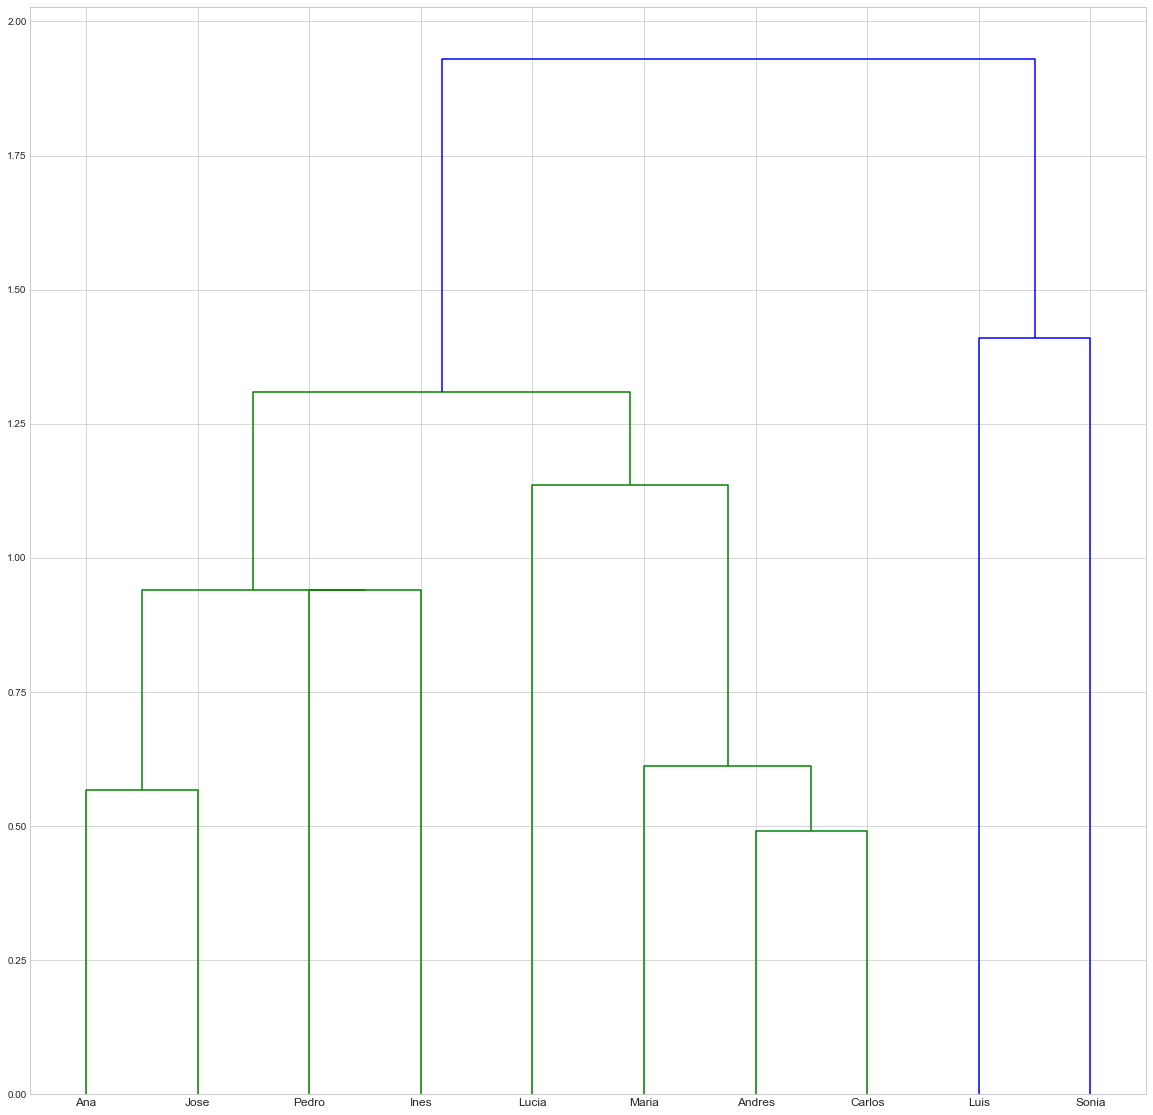

In [21]:
process4.idenfity_hierarchical_cluster()
process4.plot_dendogram()

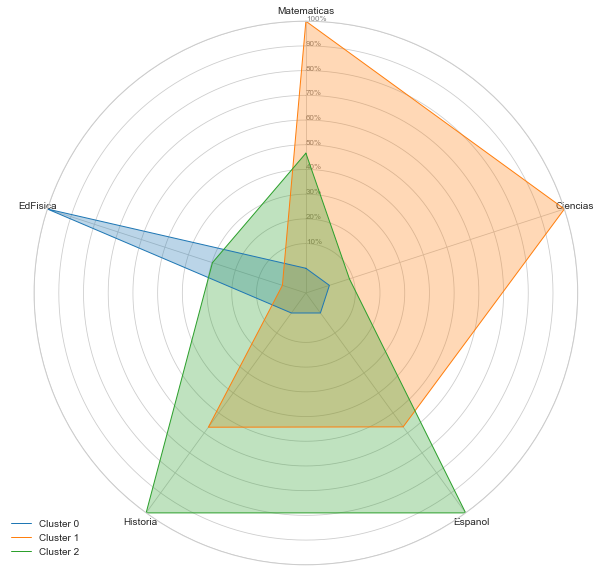

In [22]:
process4.draw_radar()

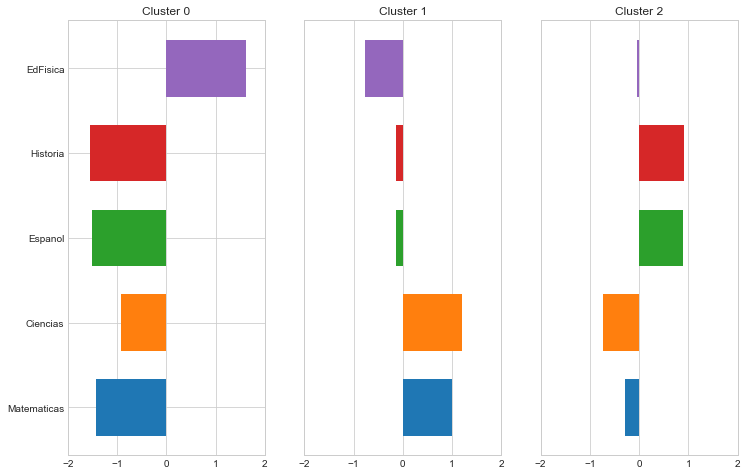

In [23]:
process4.draw_bars()

##### Utilización de Distancia Ward

In [32]:
process5 = Process()
process5.load_data(path = "./", file = "EjemploEstudiantes.csv", delimiter = ";", decimal = ",")

        Matematicas  Ciencias   Espanol  Historia  EdFisica
Lucia      0.232631 -0.752986  1.788485  0.657923  0.658581
Pedro      0.786514  1.145849 -0.538996 -0.845901 -0.476903
Ines       0.897290  1.014894  0.318497  0.093989  0.090839
Luis      -1.982900 -0.752986 -1.518987 -0.845901  1.794065
Andres    -0.875135 -1.080371  0.073499  0.939889 -0.136258
Ana        1.118843  1.276803 -0.049000  0.093989 -1.044645
Carlos    -0.542805 -0.818463  0.563495  1.033878 -0.249807
Jose       1.229620  1.342280 -0.293998  0.093989 -1.612388
Sonia     -0.875135 -1.080371 -1.518987 -2.255735  1.453420
Maria      0.011078 -0.294647  1.175990  1.033878 -0.476903


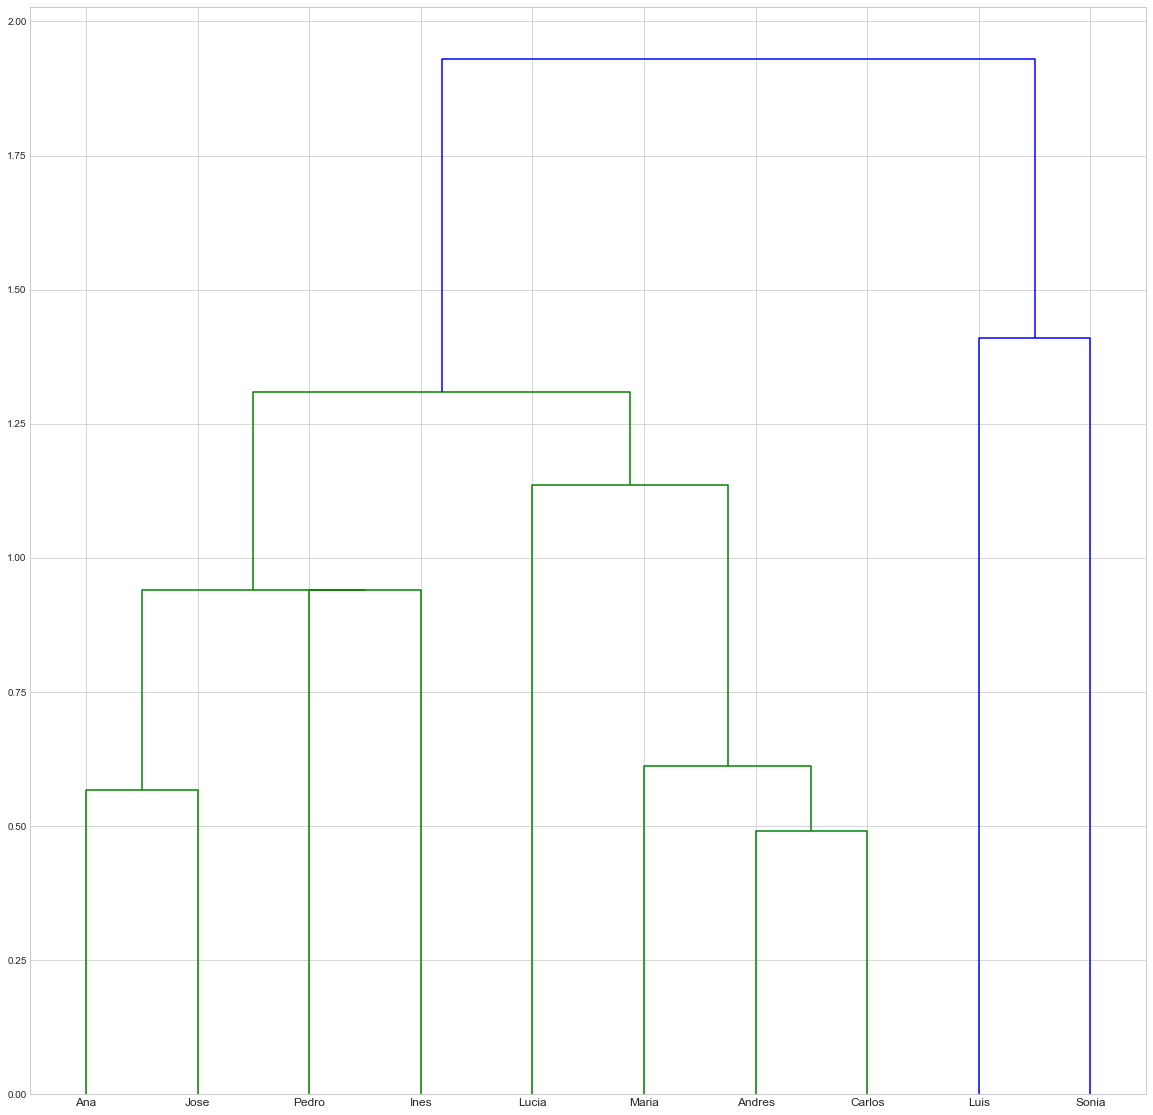

In [33]:
process4.idenfity_hierarchical_cluster(LinkageMethod.WARD)
process4.plot_dendogram()

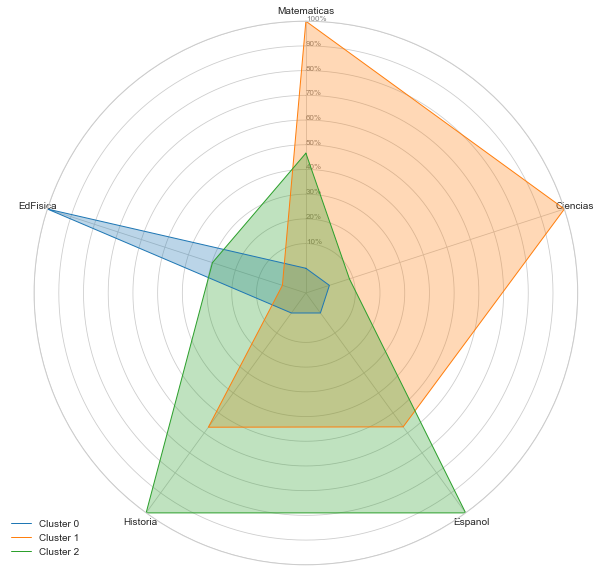

In [35]:
process5.draw_radar(method = LinkageMethod.WARD, num_clusters = 3)

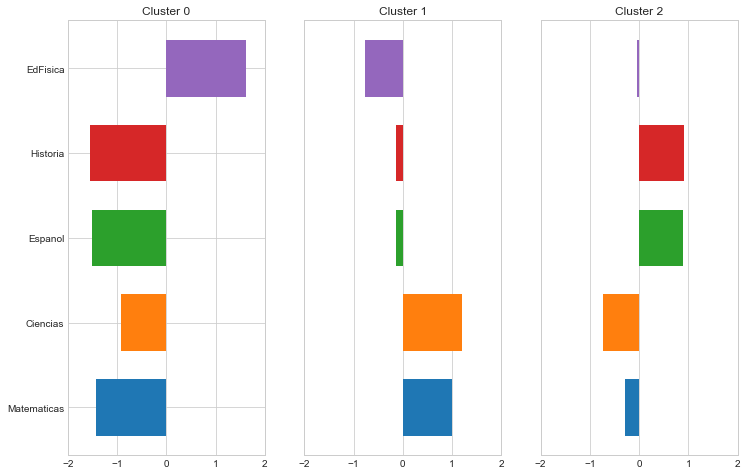

In [36]:
process5.draw_bars(method = LinkageMethod.WARD, num_clusters = 3)

> **Respuesta**
- Luego de comparar los resultados, al parecer la distancia Chebycev y distancia Ward manejan un cálculo similar por lo que no se reflejan diferencias en la interpretación